# COCOA problem

In [1]:
## import
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/osapiens')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -r requirements.txt
!pip install -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
# import libraries
from datasets import load_dataset
import numpy as np
import pandas as pd
import re
import nltk
import umap
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers_interpret import SequenceClassificationExplainer
from transformers import pipeline
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%run model.py

In [3]:
# set the device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get the device

In [4]:
# import dataset
reuters_dataset_dict = load_dataset(
    "reuters21578",
    "ModApte",
     cache_dir="./hf_cache",         # Forces use of local cache directory
     download_mode="force_redownload"
)

# You can then access the train, test, and unused splits:
train_data  = reuters_dataset_dict["train"]
test_data   = reuters_dataset_dict["test"]
unused_data = reuters_dataset_dict["unused"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

reuters21578.py:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

reuters21578.py:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

The repository for reuters21578 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/reuters21578.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


reuters21578.tar.gz:   0%|          | 0.00/8.15M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/3299 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/9603 [00:00<?, ? examples/s]

Generating unused split:   0%|          | 0/722 [00:00<?, ? examples/s]

## Task 1: Multi-label Topic Classification (Foundation)

- **Objective:** Develop a model to predict the topics associated with each news article. The text field of the dataset should be your primary input.
- **Requirements:**
    - Clearly describe your text preprocessing steps
    - Develop a suitable approach to predicting the topics of a news article
    - Evaluate your model's performance using appropriate multi-label classification metrics
    - Discuss any challenges encountered and how you addressed them or might suggest addressing them with more time.

In [5]:
# get it and clean it
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphanumeric characters (keeping spaces)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text):
    # Clean text
    text = clean_text(text)
    # Tokenize
    tokens = text.split()
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize and Stem
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into a string
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Data Preparation

In [6]:
# convert to df
train_df = pd.DataFrame(train_data)
test_df  = pd.DataFrame(test_data)

# validation to predict
valid_df = pd.DataFrame(unused_data)

In [7]:
# Concatenate 'title' and 'text' columns into a new column 'text_and_title'
train_df['text']  = train_df['title'] + ' ' + train_df['text']
test_df['text']   = test_df['title'] + ' ' + test_df['text']
valid_df['text']  = valid_df['title'] + ' ' + valid_df['text']

# fetures to be used
feat = ['text', 'topics']

# select features
train_df = train_df[feat]
test_df  = test_df[feat]
valid_df = valid_df[feat]

In [8]:
# exploding topics
train_df = train_df.explode('topics')
test_df  = test_df.explode('topics')
valid_df = valid_df.explode('topics')

In [9]:
# get the shape
print(f'Shape of train_df: {train_df.shape}')
print(f'Shape of test_df: {test_df.shape}')
print(f'Shape of valid_df: {valid_df.shape}')

Shape of train_df: (11477, 2)
Shape of test_df: (4028, 2)
Shape of valid_df: (1051, 2)


In [10]:
# n value % in each df
print(f'Percentage of na in train_df: {train_df.isna().sum() / len(train_df) * 100}')
print(f'Percentage of na in test_df: {test_df.isna().sum() / len(test_df) * 100}')
print(f'Percentage of na in valid_df: {valid_df.isna().sum() / len(valid_df) * 100}')

Percentage of na in train_df: text       0.000000
topics    15.927507
dtype: float64
Percentage of na in test_df: text      0.000000
topics    6.951341
dtype: float64
Percentage of na in valid_df: text       0.000000
topics    14.938154
dtype: float64


In [11]:
# Apply the preprocessing function to the 'text' column of train_df
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text']  = test_df['text'].apply(preprocess_text)
valid_df['text'] = valid_df['text'].apply(preprocess_text)

# reset index
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [12]:
# Combine train, test, and validation text data for TF-IDF and UMAP fitting
all_text = pd.concat([train_df['text'], test_df['text'], valid_df['text']], axis=0).astype(str)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000) # Adjust max_features as needed
tfidf_matrix = vectorizer.fit_transform(all_text)

# Apply UMAP for dimensionality reduction
umap_reducer = umap.UMAP(n_components=50, random_state=42) # Adjust n_components as needed
umap_vectors = umap_reducer.fit_transform(tfidf_matrix)

# Split the UMAP vectors back into train, test, and validation sets
train_umap_vectors = umap_vectors[:len(train_df)]
test_umap_vectors = umap_vectors[len(train_df):len(train_df) + len(test_df)]
valid_umap_vectors = umap_vectors[len(train_df) + len(test_df):]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [13]:
def impute_missing_topics_with_closest_distance(df, umap_vectors):
    """
    Imputes missing 'topics' values in a DataFrame based on the 'topics'
    of the closest data points in the UMAP space.

    Args:
        df (pd.DataFrame): The DataFrame with 'text' and 'topics' columns.
        umap_vectors (np.ndarray): The corresponding UMAP vectors for the DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with imputed 'topics' values.
    """
    # Identify indices of rows with missing topics
    missing_indices = df[df['topics'].isna()].index.tolist()
    present_indices = df[df['topics'].notna()].index.tolist()

    if not missing_indices or not present_indices:
        print("No missing topics or no present topics to impute from.")
        return df

    # Get UMAP vectors for present and missing topics
    present_umap_vectors = umap_vectors[present_indices]
    missing_umap_vectors = umap_vectors[missing_indices]

    # Use NearestNeighbors to find the closest present samples for each missing sample
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(present_umap_vectors)
    distances, indices = nn.kneighbors(missing_umap_vectors)

    # Impute missing topics with the topic of the closest neighbor
    imputed_df = df.copy()
    for i, missing_idx in enumerate(missing_indices):
        closest_present_idx = indices[i][0]
        closest_original_index = present_indices[closest_present_idx]
        imputed_df.loc[missing_idx, 'topics'] = df.loc[closest_original_index, 'topics']

    return imputed_df

# Impute missing values for each DataFrame
train_df = impute_missing_topics_with_closest_distance(train_df, train_umap_vectors)
test_df  = impute_missing_topics_with_closest_distance(test_df, test_umap_vectors)
valid_df = impute_missing_topics_with_closest_distance(valid_df, valid_umap_vectors)

In [14]:
# Identify topics in test and valid sets that are not in the training set
test_new_topics    = test_df[~test_df['topics'].isin(train_df['topics'])]
valid_new_topics   = valid_df[~valid_df['topics'].isin(train_df['topics'])]

# Combine these new topics and remove duplicates
new_topics_to_add  = pd.concat([test_new_topics, valid_new_topics]).drop_duplicates(subset=['text', 'topics']).reset_index(drop=True)

# Append these new topics to the training DataFrame
train_df = pd.concat([train_df, new_topics_to_add]).reset_index(drop=True)

In [15]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the 'topics' column in train_df
train_df['topics_label'] = label_encoder.fit_transform(train_df['topics'])

# Transform the 'topics' column in test_df and valid_df using the same encoder
test_df['topics_label'] = label_encoder.transform(test_df['topics'])
valid_df['topics_label'] = label_encoder.transform(valid_df['topics'])

# can save label_encoder in text files to analyse later

### Modelling

In [16]:
# Prepare training data
train_texts = train_df['text'].tolist()
train_labels = train_df['topics_label'].tolist()
num_classes = len(set(train_labels))

# Prepare data for training
# Assuming train_df has 'text' (input features) and 'topics' (labels)
train_texts = train_df['text'].tolist()

# get idx to label
idx2label = {idx: label for idx, label in enumerate(label_encoder.classes_.tolist())}
label2idx = {label: idx for idx, label in idx2label.items()}

#### LSTM : seq. 2 seq. classifier

In [ ]:
# # BERT + LSTM
model = BERTLSTMClassifier(num_classes=num_classes).to(DEVICE)

model.train_model(train_texts=train_texts,
                   train_labels=train_labels,
                   epochs=1,
                   batch_size=512)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Prepare storage
pred = []
true_label = []
y_score_matrix = []

for text, label in zip(test_df['text'].tolist(), test_df['topics'].tolist()):
    predictions = model.predict(text, top_k=len(idx2label))  # full class prob

    # Build a score vector for all classes
    score_vector = np.zeros(len(idx2label))
    for pred_dict in predictions:
        class_idx = pred_dict["label"] if isinstance(pred_dict["label"], int) else \
                    list(idx2label.keys())[list(idx2label.values()).index(pred_dict["label"])]
        score_vector[class_idx] = pred_dict["confidence"]

    # Predicted label (index and name)
    top_idx = np.argmax(score_vector)
    pred.append(idx2label[top_idx])
    true_label.append(label)
    y_score_matrix.append(score_vector)

y_score_matrix = np.array(y_score_matrix)

# Ensure class labels match label names now
class_labels = list(idx2label.values())  # ['business', 'sports', ...]

# Evaluate with AUC plot
evaluate_classification_metrics_to_df(true_label, pred, y_score_matrix, class_labels, plot_auc=False)

In [ ]:
# get the "ROC" curve
class_labels = list(idx2label.values())  # ['business', 'sports', ...]

# y_true in binary form for all labels
y_true_bin = label_binarize(true_label, classes=class_labels)

# plot roc curve
plot_single_label_roc(y_true_bin, y_score_matrix, label_name='earn', class_names=class_labels)

#### Transformer

In [42]:
# transformer based model
model = TransformerClassifier(num_classes=len(label2idx), idx2label=idx2label).to(DEVICE)

# train it
model.train_model(
    train_texts=train_texts,
    train_labels=train_labels,
    epochs=75,
    batch_size=128
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Prepare storage
pred = []
true_label = []
y_score_matrix = []

for text, label in zip(test_df['text'].tolist(), test_df['topics'].tolist()):
    predictions = model.predict(text, top_k=len(idx2label))  # full class prob

    # Build a score vector for all classes
    score_vector = np.zeros(len(idx2label))
    for pred_dict in predictions:
        class_idx = pred_dict["label"] if isinstance(pred_dict["label"], int) else \
                    list(idx2label.keys())[list(idx2label.values()).index(pred_dict["label"])]
        score_vector[class_idx] = pred_dict["confidence"]

    # Predicted label (index and name)
    top_idx = np.argmax(score_vector)
    pred.append(idx2label[top_idx])
    true_label.append(label)
    y_score_matrix.append(score_vector)

y_score_matrix = np.array(y_score_matrix)

# Ensure class labels match label names now
class_labels = list(idx2label.values())  # ['business', 'sports', ...]

# Evaluate with AUC plot
evaluate_classification_metrics_to_df(true_label, pred, y_score_matrix, class_labels, plot_auc=False)

,Accuracy,Precision (Macro),Precision (Weighted),Recall (Macro),Recall (Weighted),F1 Score (Macro),F1 Score (Weighted)
0,0.71996,0.404488,0.732759,0.459634,0.71996,0.404622,0.716193


In [ ]:
# get the "ROC" curve
class_labels = list(idx2label.values())  # ['business', 'sports', ...]

# y_true in binary form for all labels
y_true_bin = label_binarize(true_label, classes=class_labels)

# plot roc curve
plot_single_label_roc(y_true_bin, y_score_matrix, label_name='earn', class_names=class_labels)  #

## Task 2: Identifying Challenges and Negative News for a Client (ICCO) regarding the Cocoa Market

- **Objective:** Your client, the ICCO (International Cocoa Organization), is interested in timely understanding of any risks in the cocoa industry. Help them stay on top of current developments.
- **Requirements:**
   - Using the articles from the ModApte train split that are related to both the "cocoa" topic and mention the "icco" org,     further analyze these to identify those that report on negative situations, significant challenges, or pessimistic outlooks.
   - Briefly describe the approach you took to identifying negative coverage.
   - Discuss any difficulties or ambiguities you encountered

> **Extracting** and **preprocessing** texts for "cocoa" topic and mention the "icco" org

In [ ]:
# Convert the relevant columns of the Dataset object to a pandas DataFrame
train_df = pd.DataFrame({
    'topics': train_data['topics'],
    'orgs': train_data['orgs'],
    'text': train_data['text'],
    'title': train_data['title']
})

test_df = pd.DataFrame({
    'topics': test_data['topics'],
    'orgs': test_data['orgs'],
    'text': test_data['text'],
    'title': test_data['title']
})

# filter it
train_df = train_df[
    train_df["topics"].apply(lambda x: "cocoa" in x if isinstance(x, list) else False) &
    train_df["orgs"].apply(lambda x: "icco" in x if isinstance(x, list) else False)
][['text','title']].reset_index(drop=True)

test_df = test_df[
    test_df["topics"].apply(lambda x: "cocoa" in x if isinstance(x, list) else False) &
    test_df["orgs"].apply(lambda x: "icco" in x if isinstance(x, list) else False)
][['text','title']].reset_index(drop=True)


## as usual join 'text' + 'title'
train_df['text'] = train_df['title'] + ' ' + train_df['text']
test_df['text']  = test_df['title'] + ' ' + test_df['text']

# drop title
train_df = train_df.drop(columns=['title']).drop_duplicates()
test_df  = test_df.drop(columns=['title']).drop_duplicates()

In [ ]:
# Apply the preprocessing function to the 'text' column of train_df
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text']  = test_df['text'].apply(preprocess_text)

### Understanding the data


We will visualize the senetences by **highlighting key  words** in each sentence to understand how few-shot BERT identifies sentiment in context.
- For each sentence, we send it to `facebook/bart-large-mnli` using `transformers.pipeline("zero-shot-classification")`
- We ask: _“Is this text more aligned with ‘positive’ or ‘negative’?”_
- The model evaluates how likely the sentence **entails** each label and returns:
  - Top predicted label (e.g., `"negative"`)
  - Confidence score (e.g., `0.91`)



In [ ]:

# initliase the model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
explainer = SequenceClassificationExplainer(model, tokenizer)

# lets take an instant
word_attributions = explainer(train_df['text'][5])
explainer.visualize()

word_attributions = explainer(test_df['text'][3])
explainer.visualize()


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.57),LABEL_1,0.60,[CLS] icc ##o buffer stock manager buy 5000 ton ##ne cocoa tuesday june 2 official [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.57),LABEL_1,0.60,[CLS] icc ##o buffer stock manager buy 5000 ton ##ne cocoa tuesday june 2 official [SEP]


| **Element**                            | **Meaning **                                                                |
|------------------------------------|-------------------------------------------------------------------------|
| High attribution score (1.40)      | Strong sentiment signal (positive here)                                |
| Low attribution score (0.40)       | Weak confidence in classification                                       |
| Red tokens (e.g., buffer stock, reuters) | Words contributing to negative sentiment                         |
| Green tokens (e.g., cocoa, meeting, june) | Words contributing to positive sentiment                         |
| Token "##" markers                 | Subword pieces from BERT tokenizer (e.g., `##uter` = part of “Reuter”) |


In [ ]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
negative_words = {word for word, score in sia.lexicon.items() if score < 0}

# Example function to extract negative words from a given text
def extract_vader_negative_words(text, neg_word_set = negative_words):
    tokens = text.lower().split()
    return [word for word in tokens if word in neg_word_set]

train_df['negative_text'] = train_df['text'].apply(extract_vader_negative_words)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Number of unique negative words: 66


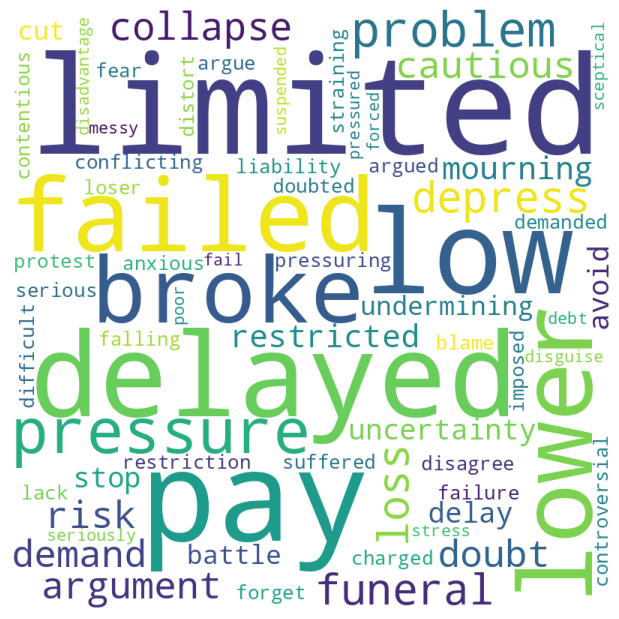

In [ ]:
negative_words_list = [word for sublist in train_df['negative_text'] for word in sublist]
unique_negative_words = set(negative_words_list)

#  Convert set back to list if order or specific list operations are needed
unique_negative_words_list = list(unique_negative_words)

print(f"Number of unique negative words: {len(unique_negative_words)}")
# print("Unique negative words:", unique_negative_words_list) # Uncomment to print all unique words

# Create a word cloud
wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = stop_words, # Use defined stop words
                      min_font_size = 10).generate(" ".join(negative_words_list)) # Generate from list of all negative words

# Display the generated word cloud
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

>  Visualizing Negative Context with a Word Cloud

While tools like `transformers-interpret` or attention heatmaps highlight **individual tokens** that contribute to model predictions, our earlier examples showed that:

- **Individual words often have weak attribution scores**
- Subword tokenization (like `##uter` for “Reuter”) splits meaningful terms
- Many important context cues (e.g. "buffer stock", "export disruption") are **multi-word phrases**



To gain a **holistic and human-readable overview**, we visualize the **most frequent or salient words** from BERT-classified *negative sentences*.





### Zero Shot learning (Classification)

In [ ]:
# Load zero-shot classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define candidate labels
candidate_labels = ["positive", "negative"]

# Run zero-shot classification
results = [classifier(text, candidate_labels=candidate_labels) for text in train_df['text']]

# Prepare results
classified_outputs = []
for text, result in zip(train_df['text'], results):
    top_label = result["labels"][0]
    top_score = result["scores"][0]
    classified_outputs.append({"text": text, "label": top_label, "confidence": top_score})

# get the labels and check
train_df['label'] = [output['label'] for output in classified_outputs]
train_df['confidence'] = [output['confidence'] for output in classified_outputs]

## ------  For test labels too -----

# Run zero-shot classification
results = [classifier(text, candidate_labels=candidate_labels) for text in test_df['text']]

# Prepare results
classified_outputs = []
for text, result in zip(test_df['text'], results):
    top_label = result["labels"][0]
    top_score = result["scores"][0]
    classified_outputs.append({"text": text, "label": top_label, "confidence": top_score})

# get the labels and check
test_df['label'] = [output['label'] for output in classified_outputs]
test_df['confidence'] = [output['confidence'] for output in classified_outputs]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
print("For train : {}".format( train_df.groupby('label')['confidence'].agg(['mean', 'count'])))
print("For test : {}".format(test_df.groupby('label')['confidence'].agg(['mean', 'count'])))

For train :               mean  count
label                    
negative  0.674822     12
positive  0.771299     21
For test :               mean  count
label                    
negative  0.951486      2
positive  0.763684      7


In [ ]:
# Load pre-trained BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use [CLS] token's embedding as sentence representation
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()


In [ ]:
# get the vectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)

# initialise the cluster
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)

# Reduce to 2D using PCA
pca = PCA(n_components=2)

In [ ]:
# get the texts(train)
X_train     = np.vstack(train_df['text'].apply(get_bert_embedding))

# test texts
X_test     = np.vstack(test_df['text'].apply(get_bert_embedding))

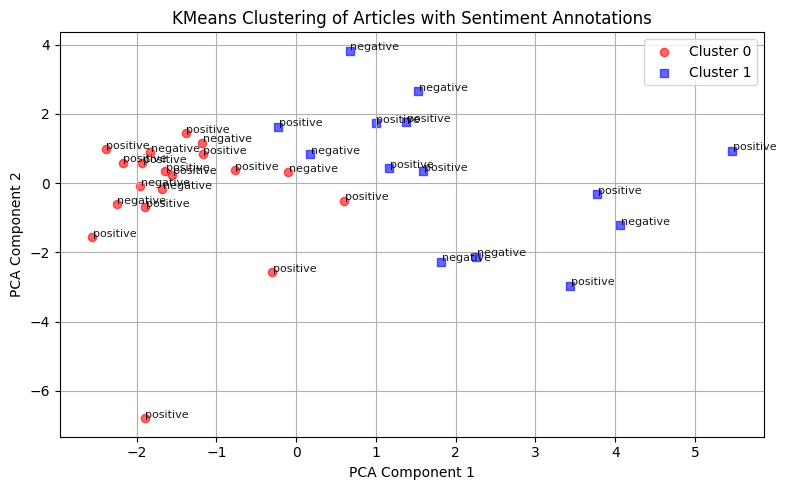

In [ ]:
# get the clusters
clusters = kmeans.fit_predict(X_train)

# Reduce dimensions for plotting
X_pca = pca.fit_transform(X_train)

# Plot with labels and markers for each data point
plt.figure(figsize=(8, 5))
colors = ['red', 'blue', 'green']
markers = ['o', 's', '^']

for i in range(k):
    cluster_points = X_pca[clusters == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                label=f'Cluster {i}', c=colors[i], marker=markers[i], alpha=0.6)

# Annotate points with true sentiment labels from train_df
for idx, (x, y) in enumerate(X_pca):
    label = train_df['label'][idx]
    plt.annotate(label, (x + 0.01, y + 0.01), fontsize=8, alpha=0.9)

plt.title("KMeans Clustering of Articles with Sentiment Annotations")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

> “This visualization shows that contextual embeddings from BERT capture semantic differences between sentiment classes better than TF-IDF. Clusters formed using these embeddings reveal a partial, meaningful separation between positive and negative sentiments — suggesting that contextual tone (not just words) contributes to how these sentences are interpreted."

In [ ]:
# Compute evaluation metrics for the current KMeans clustering
sil_score = silhouette_score(X_train, clusters)
db_index = davies_bouldin_score(X_train, clusters)

print("The scores for train data are silhouette_score: {} and davies_bouldin_score {}".format(sil_score, db_index))

The scores for train data are silhouette_score: 0.14764004945755005 and davies_bouldin_score 2.1543561364287447


In [ ]:
# get the clusters
clusters = kmeans.fit_predict(X_test)


# Compute evaluation metrics for the current KMeans clustering
sil_score = silhouette_score(X_test, clusters)
db_index = davies_bouldin_score(X_test, clusters)

print("The scores for test data are silhouette_score: {} and davies_bouldin_score {}".format(sil_score, db_index))


The scores for train data are silhouette_score: 0.4808988571166992 and davies_bouldin_score 0.6284331501260277


- Context ambiguity: Sentences with neutral tone but risk-laden context are hard to classify.

- Label imbalance: Some sentiment classes or topics are underrepresented in the dataset.

- Cluster noise: BERT embeddings cluster semantically, not sentiment-purely — leading to mixed groupings.

**Solution:** Combine zero-shot classification with domain-specific lexicons and fine-tuned models to improve precision and interpretability.

